In [1]:
from copy import deepcopy
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch

from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators import generators, generator_default_options
from xopt.generators.bayesian import MOBOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


In [ ]:
options = MOBOGenerator.default_options()
options.n_initial = (2,)
options.optim.num_restarts = 1
options.optim.raw_samples = 50
options.acq.proximal_lengthscales = [1.0, 1.0]
options.model.use_low_noise_prior = True

generator = MOBOGenerator(tnk_vocs, options)

evaluator = Evaluator(function=evaluate_TNK)

X = Xopt(generator=generator, evaluator=evaluator, vocs=tnk_vocs)
X.submit_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0]}))

In [ ]:
for i in range(100):
    X.step()

In [ ]:
fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)


ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

In [ ]:
ax = history.plot("x1", "x2")
ax.set_ylim(0, 3.14)
ax.set_xlim(0, 3.14)
ax.set_aspect("equal")

In [ ]:
from xopt.generators.bayesian.utils import feasibility

bounds = generator.vocs.bounds
model = generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, generator.sampler, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

# One-dimensional optimization

In [2]:
def f(inputs: Dict) -> Dict:
    return {"y": inputs["x"] ** 2}


In [3]:
vocs = VOCS(variables={"x": [-2, 2]}, objectives={"y": "MINIMIZE"})
vocs

VOCS(variables={'x': [-2.0, 2.0]}, constraints={}, objectives={'y': 'MINIMIZE'}, constants={}, linked_variables={})

In [4]:
options = generator_default_options["upper_confidence_bound"]
# modify the UCB beta parameter and the number of initial samples
options.n_initial = 3
options.acq.beta = 1.0

In [5]:
generator = generators["upper_confidence_bound"](vocs=vocs, options=options)
generator.options

UCBOptions(optim=OptimOptions(num_restarts=5, raw_samples=20, sequential=True, use_nearby_initial_points=True), acq=UpperConfidenceBoundOptions(proximal_lengthscales=None, monte_carlo_samples=128, beta=1.0), model=ModelOptions(use_conservative_prior_lengthscale=False, use_conservative_prior_mean=False, use_low_noise_prior=False), n_initial=3)

In [6]:
evaluator = Evaluator(function=f)

/var/folders/fl/7z0_lz612sz9d31z6p9fj81h0000gr/T/ipykernel_22994/1047454529.py:1: DeprecationWarning: `copy_on_model_validation` should be a string: 'deep', 'shallow' or 'none'
  evaluator = Evaluator(function=f)


In [7]:
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options

XoptOptions(asynch=False, strict=False, dump_file=None, max_evaluations=None)

In [8]:
X.submit_data(pd.DataFrame({"x":[-1.5, 0.75,2.0]}))
for i in range(20):   
    X.step()

Text(0, 0.5, 'y')

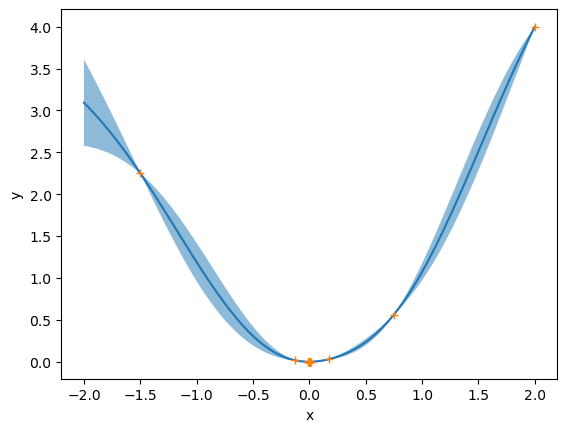

In [9]:
model = X.generator.model
bounds = X.vocs.bounds

test_x = torch.linspace(*bounds.flatten(), 100).double()

train_x = torch.tensor(X.data["x"].to_numpy())
train_y = torch.tensor(X.data["y"].to_numpy())

fig, ax = plt.subplots()
with torch.no_grad():
    post = model.models[0].posterior(test_x.reshape(-1,1,1))
    mean = post.mean.flatten()
    std = post.variance.sqrt().flatten()

    lower = mean - std
    upper = mean + std

ax.plot(test_x, mean)
ax.fill_between(test_x, lower, upper, alpha=0.5)
ax.plot(
    train_x.flatten(),
    train_y.flatten(),
    "+"
)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [10]:
print(generator.generate(1))

          x
0 -0.006791


In [11]:
from phasescan import phasescan
import argparse
import os
import acsys
from acsys import dpm as dpms

In [ ]:
def run(readfile,ramplist,Nmeas,event,outfile):
    ps = phasescan()
    ps.swap_dict()
    pwd = os.getcwd()

    readfile  =   os.path.join(pwd,readfile)
    outfile   =   os.path.join(pwd,outfile)
    
    read_list = ps.readList(readfile)
    
    set_list = ['%s%s'%(s.replace(':','_'),event) for s in ramplist[0] if str(s).find(':')!=-1] if len(ramplist)>0 else []

    drf_list = set_list+['%s%s'%(l,evt) for l in read_list if len(read_list)!=0]
    
    thread = 'scanner'

    timeout = 3540 #59 min
    
    try:
        ps.start_thread('%s'%thread,timeout,drf_list,ramplist,ps.role,Nmeas)
        
    except Exception as e:
        print('Scan failed',e)


    scanresults = []
    while len(ps.get_list_of_threads())>0:
        scanresults.extend(ps.get_thread_data('%s'%thread))
    try:
        ps.fill_write_dataframe_oneTS(scanresults,read_list,outfile)
    except Exception as e:
        print('Something went wrong',e)
        
    ps.stop_all_threads()


In [ ]:

ramplist = [
['0','Z:CUBE_X',136.0,'Z:CUBE_Y',40.0,'Z:CUBE_Z',80.0],
['1','Z:CUBE_X',134.0,'Z:CUBE_Y',40.2,'Z:CUBE_Z',80.1],
['1','Z:CUBE_X',140.0,'Z:CUBE_Y',40.3,'Z:CUBE_Z',80.2],
['1','Z:CUBE_X',142.0,'Z:CUBE_Y',39.4,'Z:CUBE_Z',80.3],
['1','Z:CUBE_X',144.0,'Z:CUBE_Y',40.4,'Z:CUBE_Z',80.4],
['1','Z:CUBE_X',146.0,'Z:CUBE_Y',41.4,'Z:CUBE_Z',80.5],
]

evt = '@e,52,e,0'
#evt = '@i'
run('Reading_devices.csv',ramplist,1,evt,'testout.csv')

In [12]:
async def read_once(con,drf_list):

    settings = [None]*len(drf_list)
    async with dpms.DPMContext(con) as dpm:

        for i, dev in enumerate(drf_list):
            await dpm.add_entry(i, dev+'@q')
        await dpm.start()
        
        async for reply in dpm.replies():
            if reply.isReading:
                settings[reply.tag]= reply.data
            if settings.count(None)==0:
                break

    print(settings)
    return None


In [13]:
async def set_once(con,set_list,read_list,value_list,settings_role):

    setpairs = list(enumerate(value_list))

    drf_list = set_list+read_list
    settings = [None]*len(drf_list)
    async with dpms.DPMContext(con) as dpm:
        await dpm.enable_settings(role=settings_role)
        for i, dev in enumerate(drf_list):
            await dpm.add_entry(i, dev+'@q')
        await dpm.start()
        
        await dpm.apply_settings(setpairs)
        print('settings applied')

        async for reply in dpm.replies():
            if reply.isReading:
                settings[reply.tag]= reply.data
            if settings.count(None)==0:
                break

    print(settings)
    return None


In [14]:
sets = ['Z:CUBE_X.SETTING','Z:CUBE_Z.SETTING']
reads = ['Z:CUBE_X','Z:CUBE_Y','Z:CUBE_Z']
vals = [170.0,60]
acsys.run_client(read_once,drf_list=reads)
acsys.run_client(set_once, set_list=sets, read_list=reads,value_list=vals,settings_role='testing') 

[170.0, 41.400001525878906, 60.0]
settings applied
[170.0, 60.0, 170.0, 41.400001525878906, 60.0]
